(ch_bcast_add_cpu)=
# CPU 广播加法

本节讨论调度 CPU 上 {ref}`ch_bcast_add` 中定义的广播加法计算。它的优化类似于对 {ref}`ch_vector_add_cpu` 所做的，因为它们本质上都是内存绑定的元素级计算。因此，在本节中，将讨论“什么不起作用”，而不是“什么起作用”。

## 设置


In [1]:
%matplotlib inline
from tvm_book.contrib import d2ltvm
# import inspect
from IPython import display
import numpy as np
from matplotlib import pyplot as plt
import timeit
import tvm
from tvm import te

这里，选择在 {ref}`fig_bcast_add` 中描述的广播加法。其他的广播模式没有本质的区别。

首先，在 `numpy` 中定义基线。在 x 轴上使用实际使用的数据大小。

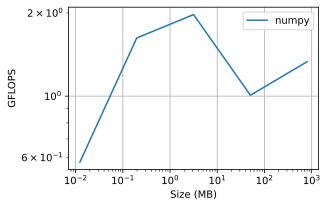

In [2]:
sizes = 2**np.arange(5, 15, 2)

def np_bcast_add(s1, s2):
    setup = ('import numpy as np\n'
             'from tvm_book.contrib.d2ltvm import get_bcast_data\n'
             f'a, b, c = get_bcast_data({s1}, {s2})')
    return timeit.Timer('np.add(a, b, out=c)', setup)


exe_times = [d2ltvm.bench_workload(
    np_bcast_add((n, 1), (n, n)).timeit) for n in sizes]
np_gflops = sizes * sizes / 1e9 / np.array(exe_times)
# data size in MB
x_axis_sizes = (sizes * sizes * 2 + sizes * sizes) * 4 / 1e6
d2ltvm.plot_gflops(x_axis_sizes, [np_gflops], ['numpy'], xlabel='Size (MB)')

请注意，x 轴表示所消耗的总数据大小。当数据大小大于单核的 L2 缓存（1024 KB 或 1 MB）时，性能会下降，这间接表明 `numpy` 可能使用单线程来执行这个算子。

## 良好的调度

下面的代码块为 TVM 中特定模式的广播添加定义了基准测试方法。它遵循在 {ref}`ch_vector_add_cpu` 中讨论的格式。

In [3]:
# Save to the d2ltvm package.
def bench_bcast_add_tvm(func, sizes, target):
    ctx = tvm.device(target, 0)
    def workload(nrepeats):
        timer = mod.time_evaluator(mod.entry_name, ctx, number=nrepeats)
        return timer(a, b, c).mean * nrepeats
    times = []
    for n in sizes:
        n = int(n)
        s, (A, B, C) = func(n)
        mod = tvm.build(s, [A, B, C], target)
        a, b, c = d2ltvm.get_bcast_data((n, 1), (n, n), lambda x: tvm.nd.array(x, ctx))
        times.append(d2ltvm.bench_workload(workload))
    return sizes * sizes / 1e9 / np.array(times)

好的调度（即什么工作）遵循类似的方案定义在 {ref}`ch_vector_add_cpu`。

In [4]:
target = "llvm" #'llvm -mcpu=skylake-avx512'
def default(n):
    A, B, C = d2ltvm.broadcast_add((n, 1), (n, n))
    s = te.create_schedule(C.op)
    return s, (A, B, C)

def good_schedule(n):
    s, (A, B, C) = default(n)
    x, y = C.op.axis
    s[C].parallel(x)
    s[C].vectorize(y)
    return s, (A, B, C)

s, args = good_schedule(64)
m = tvm.lower(s, args, simple_mode=True)
print(m)

@main = primfn(A_1: handle, B_1: handle, C_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {A: Buffer(A_2: Pointer(float32), float32, [64], []),
             B: Buffer(B_2: Pointer(float32), float32, [4096], []),
             C: Buffer(C_2: Pointer(float32), float32, [4096], [])}
  buffer_map = {A_1: A, B_1: B, C_1: C}
  preflattened_buffer_map = {A_1: A_3: Buffer(A_2, float32, [64, 1], []), B_1: B_3: Buffer(B_2, float32, [64, 64], []), C_1: C_3: Buffer(C_2, float32, [64, 64], [])} {
  for (x: int32, 0, 64) "parallel" {
    let cse_var_1: int32 = (x*64)
    C[ramp(cse_var_1, 1, 64)] = (broadcast(A[x], 64) + B[ramp(cse_var_1, 1, 64)])
  }
}




现在，您应该熟悉类似 C 的伪代码了。与 {ref}`ch_vector_add_cpu` 的显著区别是，将  `A[x]` 广播到向量化 register（即 `x64(A[x]`）用于向量化加法。

让我们参照一下良好的调度。

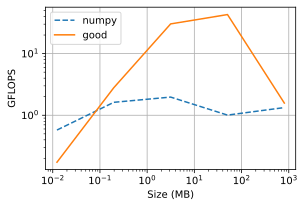

In [5]:
good_gflops = bench_bcast_add_tvm(good_schedule, sizes, target)
d2ltvm.plot_gflops(x_axis_sizes,
                   [np_gflops, good_gflops],
                   ['numpy', 'good'],
                   xlabel='Size (MB)')

就像 {ref}`ch_vector_add_cpu` 的情况，性能会更好，随着多核的使用，数据量越大，性能就会下降，从而导致 L2 缓存总量更大。

## 糟糕的调度

现在看看一个糟糕的调度（即什么不起作用）是什么样的。请注意，数据都存储在 row-major 中，调度总是确保最内层的循环在连续空间中操作数据。

然而，如果从向量化的角度考虑，可能会发现向向量化寄存器广播 `A[x]` 会带来开销。更好的方法是在向量化指令中有多个 `A`  值与多个 `B` 值相加，如 {ref}`fig_bcast_add_vectorize`。

(fig_bcast_add_vectorize)=
```{figure} ../img/bcast_add_vectorize.svg
广播加法的不同向量化策略。
```

为了沿列进行向量化，需要按如下方式对数据访问模式进行重新排序。

In [6]:
def bad_schedule(n):
    s, (A, B, C) = default(n)
    x, y = C.op.axis
    s[C].reorder(y, x)
    s[C].parallel(y)
    s[C].vectorize(x)
    return s, (A, B, C)

s, args = bad_schedule(64)
print(tvm.lower(s, args, simple_mode=True))

@main = primfn(A_1: handle, B_1: handle, C_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {A: Buffer(A_2: Pointer(float32), float32, [64], []),
             B: Buffer(B_2: Pointer(float32), float32, [4096], []),
             C: Buffer(C_2: Pointer(float32), float32, [4096], [])}
  buffer_map = {A_1: A, B_1: B, C_1: C}
  preflattened_buffer_map = {A_1: A_3: Buffer(A_2, float32, [64, 1], []), B_1: B_3: Buffer(B_2, float32, [64, 64], []), C_1: C_3: Buffer(C_2, float32, [64, 64], [])} {
  for (y: int32, 0, 64) "parallel" {
    C[ramp(y, 64, 64)] = (A[ramp(0, 1, 64)] + B[ramp(y, 64, 64)])
  }
}




现在消除向量化中 `A[x]` 的广播。让我们运行基准并绘制这个调度的图表。

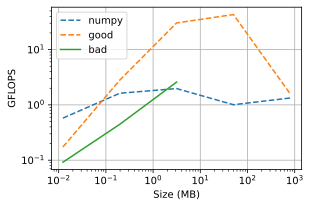

In [7]:
sizes = 2**np.arange(5, 11, 2)
bad_gflops = bench_bcast_add_tvm(bad_schedule, sizes, target)
diff = len(good_gflops)-len(bad_gflops)
bad_gflops = np.append(bad_gflops, [np.nan] * diff)
d2ltvm.plot_gflops(x_axis_sizes, [np_gflops, good_gflops, bad_gflops],
     ['numpy', 'good', 'bad'],  xlabel='Size (MB)')

注意，为了使它在短时间内完成，归约了这个调度的测试大小的数量。

可以看到有利于向量化调度的性能相当差。原因是要跨步访问 `B` 来获取同一列中的数据，这比访问连续空间中的数据要慢得多。线程级的并行性会使情况变得更糟，因为不同的线程在同一缓存线上竞争获取数据。

结果表明，好的调度需要同时考虑多个与性能相关的因素。偏袒某个方面的调度方案可能会损害其他方面，从而导致整体性能下降。

## 小结

- 和 vector add 一样，broadcast add 也是内存绑定算子。
- 好的调度需要同时考虑多个与性能相关的因素

## 练习

- 尝试调度其他的广播加法模式，并观察差异。